In [1]:
from tqdm import tqdm

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import dataset, DataLoader

In [2]:
emb_size = 3
output_classes = 10

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self, final_layer):
        super(SimpleCNN, self).__init__()
        self.base_layers = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(9216, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, emb_size)
        )
        self.final_layer = final_layer

    def get_base_layers(self, x):
        return self.base_layers(x)

    def forward(self, x):
        x = self.get_base_layers(x)

        output = self.final_layer(x)
        return output


In [4]:
class CosineComponent(nn.Module):

    def __init__(self, emb_size, output_classes):
        super().__init__()
        self.W = nn.Parameter(torch.Tensor(emb_size, output_classes))
        nn.init.kaiming_uniform_(self.W)

    def forward(self, x):
        # Step 1:
        x_norm = F.normalize(x)
        W_norm = F.normalize(self.W, dim=0)
        # Step 2:
        return x_norm @ W_norm

In [5]:
def arcface_loss(cosine, target, m=.4):
    # this prevents nan when a value slightly crosses 1.0 due to numerical error
    cosine = cosine.clip(-1+1e-7, 1-1e-7)
    # Step 3:
    arcosine = cosine.arccos()
    # Step 4:
    arcosine += F.one_hot(target, num_classes = output_classes) * m
    # Step 5:
    cosine2 = arcosine.cos()
    # Step 6:
    return F.cross_entropy(cosine2, target)

In [6]:
def train(model, device, train_loader, optimizer, loss_func, epoch,log_interval=10, dry_run=None):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)

        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if dry_run:
                break

In [7]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [8]:
# helper method to extract all embedings from a data loader
def get_embs(model, dl, device):
    embs = []
    ys = []
    for bx,by in tqdm(dl):
        bx, by = bx.to(device), by.to(device)
        with torch.no_grad():
            embs.append(model.get_base_layers(bx))
            ys.append(by)
    embs = torch.cat(embs)
    embs = embs / embs.norm(p=2,dim=1)[:,None]
    ys = torch.cat(ys)
    return embs, ys


In [9]:
# helper to plot embeddings in 3D
def plot_embs(embs, ys, ax):
    #ax.axis('off')
    for k in range(10):
        e = embs[ys==k].cpu()
        ax.scatter(e[:,0], e[:,1], e[:,2], s=4, alpha=.2)


In [10]:

train_kwargs = {'batch_size': 256}
test_kwargs = {'batch_size': 256}

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

dataset1 = datasets.MNIST('../data', train=True, download=True,
                    transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                    transform=transform)
train_loader = DataLoader(dataset1,**train_kwargs)
test_loader = DataLoader(dataset2, **test_kwargs)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.48MB/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 64.7kB/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.2MB/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [11]:
device = "cuda"
print(device)

model = SimpleCNN(CosineComponent(3, 10))
model.to(device)

optimizer = optim.Adadelta(model.parameters(), lr=1.0)

scheduler = StepLR(optimizer, step_size=1, gamma=0.7)


cuda


In [12]:
for epoch in range(1, 10 + 1):
    train(model, device, train_loader, optimizer, arcface_loss, epoch)
    test(model, device, test_loader)
    scheduler.step()

embs_arcface, ys_arcface  = get_embs(model.eval(), test_loader, device)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.714918
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.180246
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.957800
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.857153
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.754278
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.751978
Train Epoch: 1 [15360/60000 (26%)]	Loss: 1.710262
Train Epoch: 1 [17920/60000 (30%)]	Loss: 1.672554
Train Epoch: 1 [20480/60000 (34%)]	Loss: 1.652360
Train Epoch: 1 [23040/60000 (38%)]	Loss: 1.698464
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.642560
Train Epoch: 1 [28160/60000 (47%)]	Loss: 1.631375
Train Epoch: 1 [30720/60000 (51%)]	Loss: 1.662476
Train Epoch: 1 [33280/60000 (55%)]	Loss: 1.615353
Train Epoch: 1 [35840/60000 (60%)]	Loss: 1.637579
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.674163
Train Epoch: 1 [40960/60000 (68%)]	Loss: 1.622914
Train Epoch: 1 [43520/60000 (72%)]	Loss: 1.617196
Train Epoch: 1 [46080/60000 (77%)]	Loss: 1.637504
Train Epoch: 1 [48640/60000 (81%)]	Loss: 1.597166
Train Epoc

100%|██████████| 40/40 [00:02<00:00, 15.25it/s]


In [13]:
model_conv = SimpleCNN(nn.Linear(3,10))
model_conv.to(device)

optimizer_conv = optim.Adadelta(model_conv.parameters(), lr=1.0)
loss = nn.CrossEntropyLoss()

scheduler_conv = StepLR(optimizer_conv, step_size=1, gamma=0.7)


In [14]:
for epoch in range(1, 10 + 1):
    train(model_conv, device, train_loader, optimizer_conv, loss, epoch)
    test(model_conv, device, test_loader)
    scheduler_conv.step()

embs_softmax, ys_softmax  = get_embs(model_conv, test_loader, device)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.361162
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.082542
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.419870
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.483686
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.950827
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.390152
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.860206
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.701653
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.631556
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.534560
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.547675
Train Epoch: 1 [28160/60000 (47%)]	Loss: 0.432299
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.538593
Train Epoch: 1 [33280/60000 (55%)]	Loss: 0.355948
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.452311
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.344930
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.337858
Train Epoch: 1 [43520/60000 (72%)]	Loss: 0.321952
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.371867
Train Epoch: 1 [48640/60000 (81%)]	Loss: 0.373924
Train Epoc

100%|██████████| 40/40 [00:02<00:00, 19.17it/s]


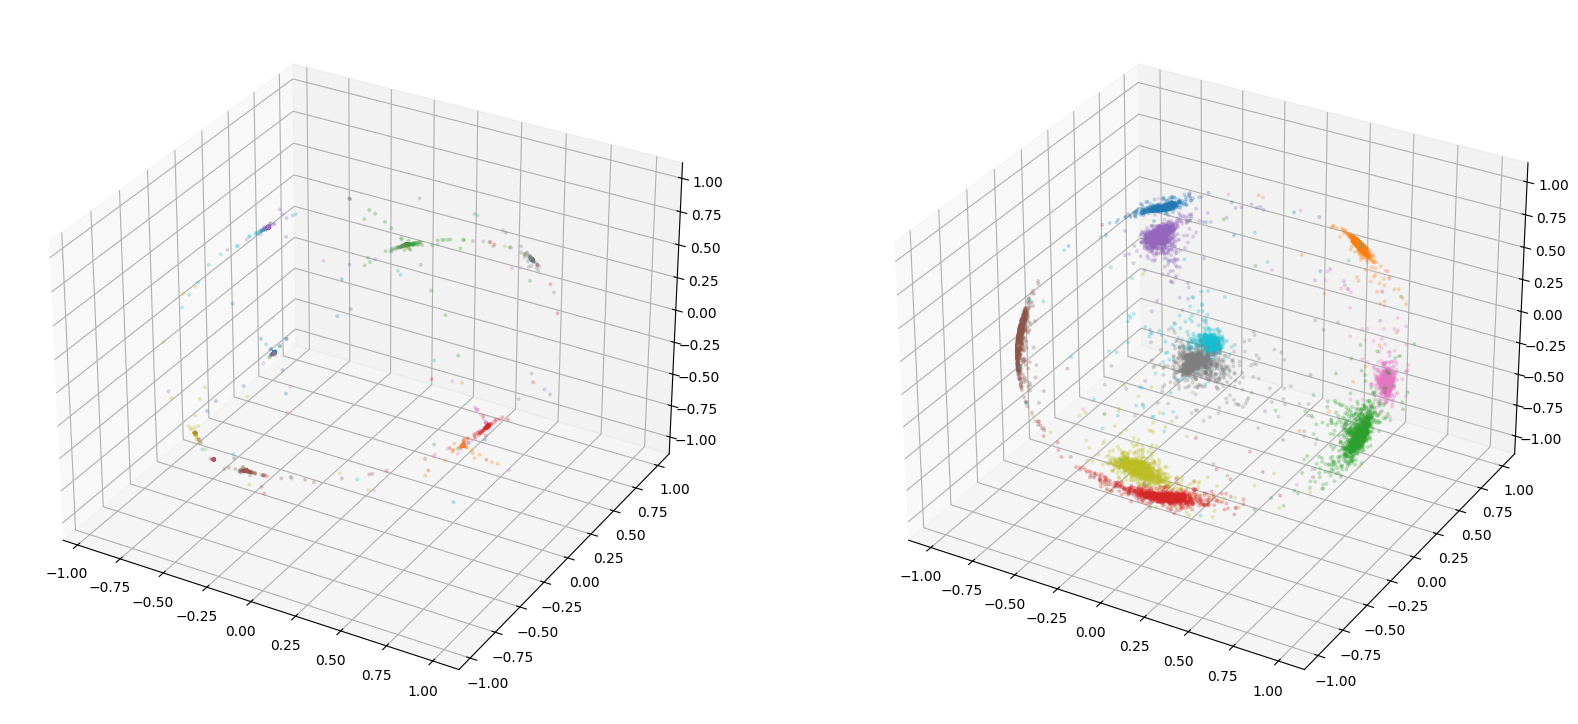

In [15]:
_,(ax1,ax2)=plt.subplots(1,2, figsize=(20,10), subplot_kw={'projection':'3d'})
plot_embs(embs_arcface, ys_arcface, ax1)
plot_embs(embs_softmax, ys_softmax, ax2)

plt.show()
